# Modern Portfolio Theory

As we often hear when talking about investing, people usually say "don't put all your eggs in one basket", But what does that sentence truly mean? Back in the day, Markowitz (1952) introduced the concept of Modern Portfolio Theory (MPT), which is a framework that helps investors build an optimal portfolio assuming that investors are willing to prefer a less risky portfolio to a riskier one, given the same expected return. The key idea introduced by MPT is that the risk of a portfolio is not just a sum of the risks of the individual assets, but rather a function of how those assets interact with each other, denoted by its covariance. That idea is what we nowadays call by *mean-variance optimization* ou *Modern Portfolio Theory*.

In these notes, i want to explore the ideia of benefits of diversification and how sensitive the mean-variance optimization is to changes in assets means, here we will do an exercise inspired by Best e Grauer (1991) article.

First, we will begin with the simplest mean-variance form
$$
\begin{align*}
\max_{w \in \Omega} &\quad t\mu^T w - \frac{1}{2} w^T \Sigma w \\
\text{s.t.} &\quad i^T w = 1
\end{align*}
$$
where $t$ is a risk tolerance parameter, where the larger it is, the more tolerant the investor is to risk, $\mu$ is the vector of expected returns, $\Sigma$ is the covariance matrix of returns, and $i$ is a vector of ones. The solution to this problem gives us the optimal weights for the assets in the portfolio. Let's construct the Lagrangian function for this problem, which is given by
$$
\mathcal{L}(w, \lambda) = t\mu^T w - \frac{1}{2} w^T \Sigma w - \lambda (i^T w - 1)
$$
The first order conditions are given by
$$
\begin{align*}
\frac{\partial \mathcal{L}}{\partial w} &= t\mu^T - \frac{1}{2}2\Sigma w - \lambda i = 0 \tag{1}\\   
\frac{\partial \mathcal{L}}{\partial \lambda} &= i^T w = 1 \tag{2}
\end{align*}
$$
we can rewrite (1) as
$$
\begin{align*}
\Sigma w &= t\mu^T - \lambda i  \\ 
w &= \Sigma^{-1} (t\mu^T - \lambda i)  \\
w &=  t \Sigma^{-1} \mu^T - \lambda \Sigma^{-1} i \tag{3}
\end{align*}
$$
Now, we can plug (3) into (2) to find the value of $\lambda$.
$$
\begin{align*}
i^T\left( t \Sigma^{-1} \mu^T - \lambda \Sigma^{-1} i \right) &= 1 \\
t i^T \Sigma^{-1} \mu^T - \lambda i^T \Sigma^{-1} i &= 1
\end{align*}
$$
in order to facilitate the notation, let's define $a = i^T \Sigma^{-1} \mu^T$ and $c = i^T \Sigma^{-1} i$, so we can rewrite the equation as
$$
\begin{align*}
a - \lambda c &= 1 \\
ta &= 1 + \lambda c \\
\lambda &= \frac{ta - 1}{c}
\end{align*}
$$
Now, we can plug the value of $\lambda$ back into (3) to find the optimal weights for the assets in the portfolio.
$$
\begin{align*}
w &=  t \Sigma^{-1} \mu^T - \frac{ta - 1}{c} \Sigma^{-1} i \\
w &=  t \Sigma^{-1} \mu^T - \left( \frac{ta}{c}- \frac{1}{c} \right) \Sigma^{-1} i \\
w &=  t \Sigma^{-1} \mu^T - \frac{ta}{c}\Sigma^{-1} i + \frac{1}{c} \Sigma^{-1} i \\
w &=  t \Sigma^{-1}\left( \mu^T - \frac{a}{c} i \right) + \frac{1}{c} \Sigma^{-1} i \tag{4}
\end{align*}
$$
As we can see, when we set the risk tolerance to zero, $t$=0, it gives the minimum variance portfolio

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

tickers = ['PETR4.SA', 'VALE3.SA', 'ITUB4.SA', 'ABEV3.SA']

data = yf.download(tickers, start='2015-01-01', end='2025-01-01', progress=False)["Close"]

YF.download() has changed argument auto_adjust default to True


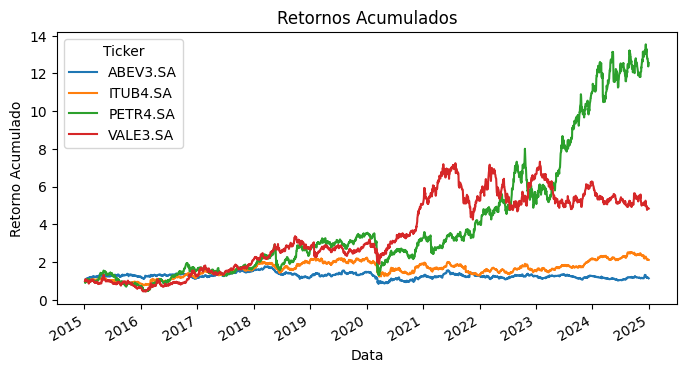

In [2]:
returns = data.pct_change()

cumulative_returns = (1 + returns).cumprod()

cumulative_returns.plot(figsize=(8,4), title="Retornos Acumulados")
plt.xlabel("Data")
plt.ylabel("Retorno Acumulado")
plt.show()

Now that we already have loaded our data and calculated the ruturns, we can start to calculate the covariance matrix and the expected returns, in order to calculate the optimal weights based on the analytical solution we just derived to get on equation (4).

In [3]:
def calculate_optimal_weights(returns, t):
    mu = returns.mean() * 252 
    sigma = returns.cov() * 252
    inv_sigma = np.linalg.inv(sigma)

    i = np.ones(len(mu))
    a = np.transpose(i) @ inv_sigma @ mu
    c = np.transpose(i) @ inv_sigma @ i
    weights = t * inv_sigma @ (mu - (a / c) * i) + (1 / c) * inv_sigma @ i

    weights_df = pd.DataFrame(weights, index=returns.columns, columns=["Weights"])
    return weights_df

optimal_weights = calculate_optimal_weights(returns, 1)
print(optimal_weights)


           Weights
Ticker            
ABEV3.SA -0.794267
ITUB4.SA -0.302752
PETR4.SA  1.498021
VALE3.SA  0.598998


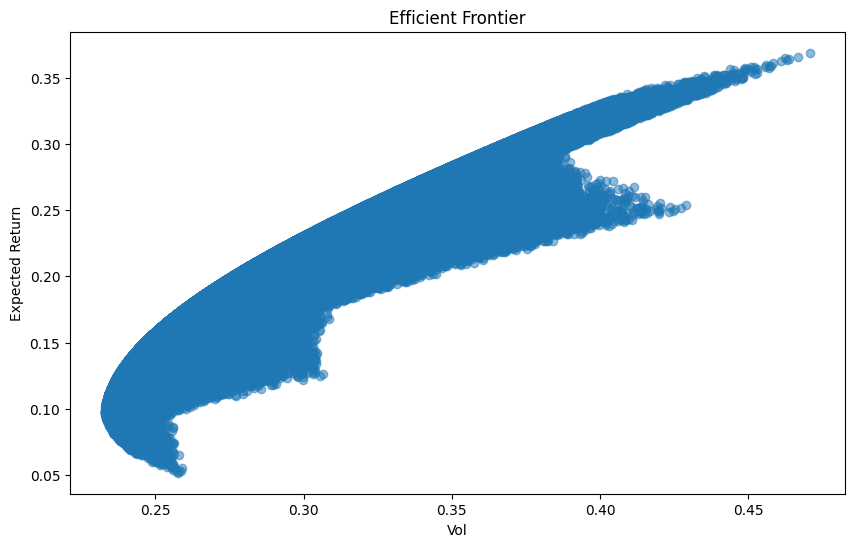

In [4]:
def calculate_efficient_frontier(returns, num_portfolios=1000000):
    mu = returns.mean()
    sigma = returns.cov()

    returns_array = np.zeros(num_portfolios)
    volatility_array = np.zeros(num_portfolios)
    weights_array = np.zeros((num_portfolios, returns.shape[1]))

    for i in range(num_portfolios):
        weights = np.random.random(returns.shape[1])
        weights /= np.sum(weights)
        weights_array[i, :] = weights

        portfolio_return = np.sum(mu * weights) * 252  
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(sigma, weights))) * np.sqrt(252)

        returns_array[i] = portfolio_return
        volatility_array[i] = portfolio_volatility

    return returns_array, volatility_array, weights_array


returns_array, volatility_array, weights_array = calculate_efficient_frontier(returns)

plt.figure(figsize=(10, 6))
plt.scatter(volatility_array, returns_array, alpha=0.5)
plt.xlabel('Vol')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier')

plt.show()


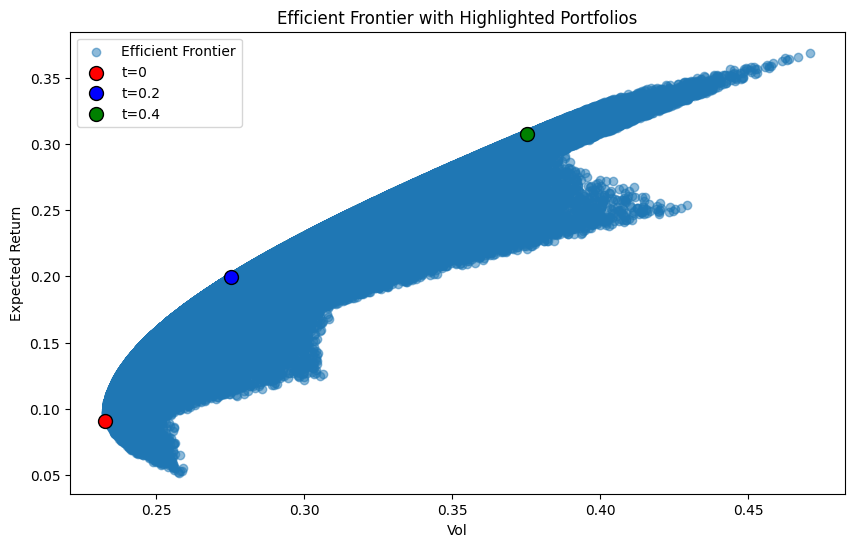

In [5]:
# Calcular os pesos para t=0, t=1 e t=2
weights_t0 = calculate_optimal_weights(returns, 0)
weights_t1 = calculate_optimal_weights(returns, 0.2)
weights_t2 = calculate_optimal_weights(returns, 0.4)

def calculate_portfolio_metrics(weights, mu, sigma):
    portfolio_return = np.sum(mu * weights)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(sigma, weights)))
    return portfolio_return, portfolio_volatility

mu = returns.mean() * 252
sigma = returns.cov() * 252

ret_t0, vol_t0 = calculate_portfolio_metrics(weights_t0.values.flatten(), mu, sigma)
ret_t1, vol_t1 = calculate_portfolio_metrics(weights_t1.values.flatten(), mu, sigma)
ret_t2, vol_t2 = calculate_portfolio_metrics(weights_t2.values.flatten(), mu, sigma)

plt.figure(figsize=(10, 6))
plt.scatter(volatility_array, returns_array, alpha=0.5, label='Efficient Frontier')
plt.scatter(vol_t0, ret_t0, color='red', label='t=0', s=100, edgecolors='black')
plt.scatter(vol_t1, ret_t1, color='blue', label='t=0.2', s=100, edgecolors='black')
plt.scatter(vol_t2, ret_t2, color='green', label='t=0.4', s=100, edgecolors='black')

plt.xlabel('Vol')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier with Highlighted Portfolios')
plt.legend()
plt.show()

In [6]:
variance_t0 = np.dot(weights_t0.values.flatten().T, np.dot(sigma, weights_t0.values.flatten()))

min_variance_index = np.argmin(volatility_array)
min_variance_weights = weights_array[min_variance_index]
min_variance = np.dot(min_variance_weights.T, np.dot(sigma, min_variance_weights))

print(f"Variância da carteira weights_t0: {variance_t0.round(4)}")
print(f"Variância da carteira de menor variância: {min_variance.round(4)}")

Variância da carteira weights_t0: 0.0542
Variância da carteira de menor variância: 0.0543


# References

* Markowitz, H. (1952). Portfolio Selection. *The Journal of Finance*, 7(1), 77–91.
* Michael J. Best, Robert R. Grauer, On the Sensitivity of Mean-Variance-Efficient Portfolios to Changes in Asset Means: Some Analytical and Computational Results, *The Review of Financial Studies*, Volume 4, Issue 2, April 1991, Pages 315–342